# Surface Mapping Using Fiducial Markers and Screen Corners

## What are Fiducial Markers?

Fiducial markers (for a review see [<sup>1</sup>](https://doi.org/10.1007/s10846-020-01307-9)) are specially designed visual patterns that serve as reference points for establishing coordinate correspondence. They are reliably detected in images, enabling transformation between image/video coordinates and real-world coordinates. In eye-tracking, they allow us to transform gaze from the camera's perspective to the observed surface (for example, a computer screen).

PyNeon supports two widely-adopted marker systems:

- **[AprilTag](https://april.eecs.umich.edu/software/apriltag)** (references<sup>[2](https://doi.org/10.1109/ICRA.2011.5979561),[3](https://doi.org/10.1109/IROS.2016.7759617)</sup>): Also used by [Pupil Labs Neon Player](https://docs.pupil-labs.com/neon/neon-player/surface-tracker/) and [Pupil Cloud](https://docs.pupil-labs.com/neon/pupil-cloud/enrichments/marker-mapper/).

- **[ArUco](https://www.uco.es/investiga/grupos/ava/portfolio/aruco/)** (reference<sup>[4](https://doi.org/10.1016/j.patcog.2014.01.005)</sup>): Integrated into OpenCV, enabling marker detection via [cv2.aruco](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html).

<p><a href="https://commons.wikimedia.org/wiki/File:Comparison_of_augmented_reality_fiducial_markers.svg#/media/File:Comparison_of_augmented_reality_fiducial_markers.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Comparison_of_augmented_reality_fiducial_markers.svg" alt="Comparison of augmented reality fiducial markers.svg" width="600"/></a>

## Sample Dataset

We use a sample dataset called "markers" containing two recordings: one with AprilTag markers and one with ArUco markers. In both, a participant viewed artworks on a computer screen. Specifically, the participant moved their head often to test robustness under larger head motion. We will map gaze and fixation data onto the screen using markers visible in the scene video. The sample data is fetched via `get_sample_data(...)` and stored locally after download.

In [1]:
from pyneon import Dataset, get_sample_data
import matplotlib.pyplot as plt

# Load a sample recording
dataset_dir = get_sample_data("markers", format="cloud")
dataset = Dataset(dataset_dir)

Let's start with the AprilTag recording (recording index 0).

In [2]:
rec = dataset.recordings[0]
print(rec)


Data format: cloud (version: 2.5)
Recording ID: 16841adb-da58-4c42-be02-f052c3c43db3
Wearer ID: 028e4c69-f333-4751-af8c-84a09af079f5
Wearer name: Pilot
Recording start time: 2025-09-22 00:25:14.096000
Recording duration: 244820000000 ns (244.82 s)



## AprilTag Example

### Visualizing Markers in Video

First, inspect a few frames to confirm the markers are clearly visible and well lit. Below are three example frames: fixation cross, artwork presentation, and inter-trial interval.

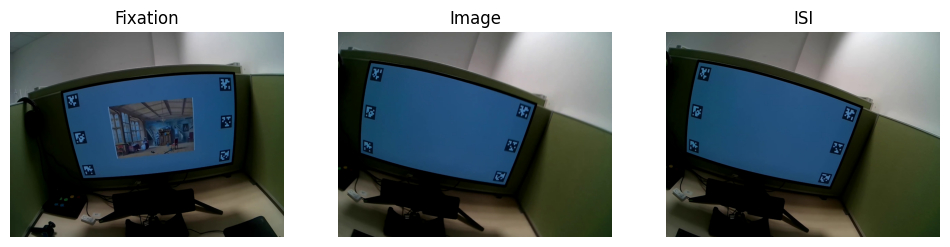

In [3]:
video = rec.scene_video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(380, ax=axs[0], show=False)
video.plot_frame(500, ax=axs[1], show=False)
video.plot_frame(520, ax=axs[2], show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.show()

### Step 1: Detect Markers

The `detect_markers()` method automatically detects AprilTag or ArUco markers. The only required argument is `marker_family` (for example, `'36h11'` for AprilTag tag36h11, omitting "tag").

Optional parameters allow customization:
- `detection_window`: restrict detection to a specific time range
- `detection_window_unit`: interpret the window as frames, seconds, or timestamps
- `step`: process every Nth frame to speed up detection
- `detector_parameters`: pass custom `cv2.aruco.DetectorParameters` for fine-tuning
- `undistort`: optionally undistort frames before detection

Here we use default settings, processing all frames:

In [4]:
from pathlib import Path
from pyneon import Stream
import os

detection_path = Path("export") / "detected_markers.csv"
if detection_path.exists():
    detected_markers = Stream(detection_path)
else:
    os.makedirs(detection_path.parent, exist_ok=True)
    detected_markers = video.detect_markers("36h11", step=10)
    detected_markers.save(detection_path)

### Verifying Detection

Detected markers are stored in a PyNeon `Stream` with timestamps from the video frames. Each row corresponds to a detection and includes the marker id and corner coordinates in the video frame.

In [5]:
print(detected_markers.data.head(20))

                     frame index marker family marker id marker name  \
timestamp [ns]                                                         
1758493517623233333           80         36h11         0     36h11_0   
1758493517623233333           80         36h11         1     36h11_1   
1758493517623233333           80         36h11         2     36h11_2   
1758493517623233333           80         36h11         5     36h11_5   
1758493517623233333           80         36h11         4     36h11_4   
1758493517623233333           80         36h11         3     36h11_3   
1758493517956444444           90         36h11         0     36h11_0   
1758493517956444444           90         36h11         1     36h11_1   
1758493517956444444           90         36h11         2     36h11_2   
1758493517956444444           90         36h11         5     36h11_5   
1758493517956444444           90         36h11         4     36h11_4   
1758493517956444444           90         36h11         3     36h

Spot-check detections by plotting markers on selected frames. This makes it easy to confirm that ids are correct and corners line up with the visual markers:

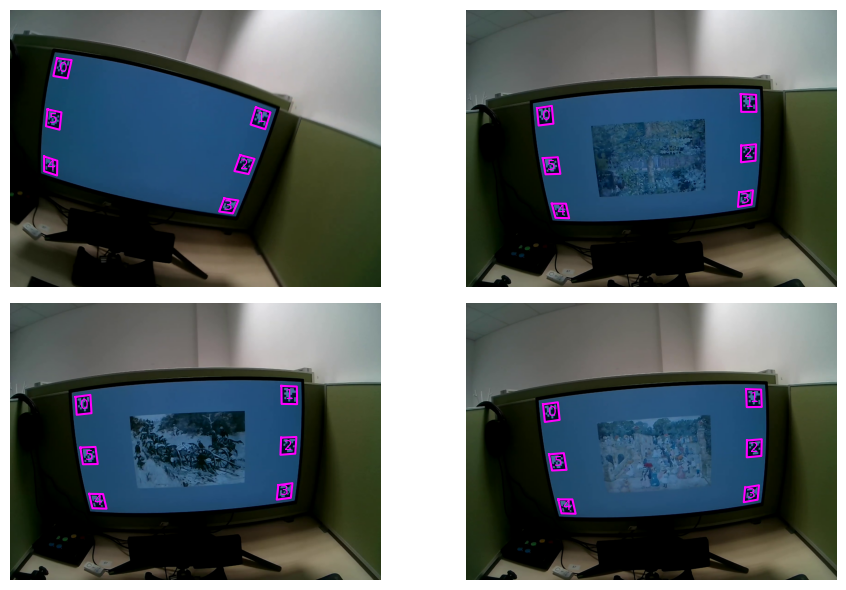

In [6]:
# Plot a few frames with detected markers
fig, axs = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
axs = axs.flatten()
video.plot_detections(detected_markers, frame_index=500, ax=axs[0], show=False)
video.plot_detections(detected_markers, frame_index=1000, ax=axs[1], show=False)
video.plot_detections(detected_markers, frame_index=1500, ax=axs[2], show=False)
video.plot_detections(detected_markers, frame_index=2000, ax=axs[3], show=False)
plt.show()

### Step 2: Define Real-World Marker Coordinates

To establish the mapping, provide a dataframe with real-world coordinates for each marker. This requires:
- **Marker name**: must match the ids reported by `detect_markers()`
- **Center coordinates**: where the marker is located in the target surface coordinate system (here, screen pixels)
- **Size**: physical marker size in the same units as the target surface

In this experiment (screen resolution 2560x1440), markers were placed near the screen corners with a 50 px margin and 200x200 px size. They are also placed in a clockwise order, starting from the top-left corner.

Once a `marker_info` dataframe is defined, we can preview it to make sure the coordinates look correct using the `plot_marker_layout()` function:

  marker name  size  center x  center y
0     36h11_0   200       150     150.0
1     36h11_1   200      2410     150.0
2     36h11_2   200      2410     720.0
3     36h11_3   200      2410    1290.0
4     36h11_4   200       150    1290.0
5     36h11_5   200       150     720.0


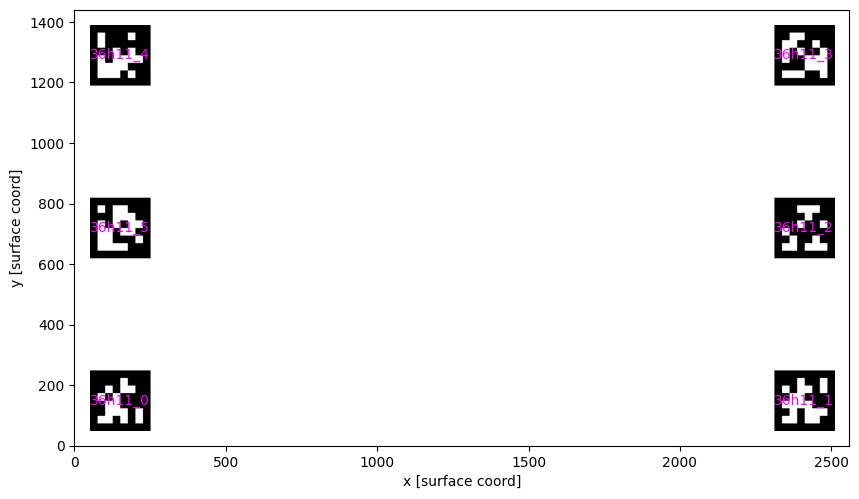

In [7]:
from pyneon.vis import plot_marker_layout
import pandas as pd

width = 2560
height = 1440
marker_layout = pd.DataFrame(
    {
        "marker name": [f"36h11_{i}" for i in range(6)],
        "size": 200,
        "center x": [150, width - 150, width - 150, width - 150, 150, 150],
        "center y": [150, 150, height / 2, height - 150, height - 150, height / 2],
    }
)
print(marker_layout)

fig, ax = plt.subplots(figsize=(10, 6))
plot_marker_layout(marker_layout, ax=ax, show_marker_names=True, show=False)
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_aspect("equal")
plt.show()

### Step 3: Compute Homography Transformation

The `find_homographies()` method computes a frame-by-frame 2D transformation (homography) between detected marker locations and their real-world coordinates. The result is a `Stream` of 3x3 homography matrices, one per frame where enough markers are available. These matrices enable mapping any point from camera coordinates to screen coordinates.

In [8]:
from pyneon.video import find_homographies

homographies = find_homographies(
    detected_markers,
    marker_layout=marker_layout,
)
print(homographies.data.head())

Computing marker homographies: 100%|██████████| 704/704 [00:01<00:00, 564.98it/s]

                     homography (0,0)  homography (0,1)  homography (0,2)  \
timestamp [ns]                                                              
1758493517623233333          2.598597         -0.442606       -850.410264   
1758493517956444444          2.398689         -0.518810       -521.535770   
1758493518622866666          2.181597         -0.593016         98.180638   
1758493518956066666          2.543775          0.059759       -604.106878   
1758493519955700000          2.060948         -0.883818       -778.448451   

                     homography (1,0)  homography (1,1)  homography (1,2)  \
timestamp [ns]                                                              
1758493517623233333          0.186317          2.581638      -1427.930238   
1758493517956444444          0.241472          2.405991      -1316.174140   
1758493518622866666          0.178565          2.187251      -1011.426951   
1758493518956066666         -0.274775          1.679668       -406.181767  

### Step 4: Apply Transformation to Gaze Data

Now apply the homography transformation to project gaze and fixations onto screen coordinates. This is done using the `apply_homographies()` method of gaze and fixation objects. Internally, PyNeon interpolates the homographies to the timestamps of the gaze and fixation samples and applies the closest valid transform.

You might notice warning messages. They are expected when homographies are missing for some frames (for example, markers were not visible or were blurred). If the nearest homography is too far from a sample time (default 500 ms), the sample is dropped. You can change this behavior with the `max_gap_ms` argument.

In [9]:
gaze_on_surface = rec.gaze.apply_homographies(homographies)
fixations_on_surface = rec.fixations.apply_homographies(homographies)

C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:67: UserWarning: 234 out of 48219 requested timestamps are outside the data time range and will have empty data.
  warn(
C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\preprocess\preprocess.py:110: UserWarning: 1401 out of 48219 requested timestamps exceed max_gap_ms=500 relative to neighboring samples and will have empty data.
  warn(
Applying homographies to gaze points:  16%|█▌        | 7543/46584 [00:05<00:29, 1312.27it/s]


KeyboardInterrupt: 

Now let's plot all the mapped gaze and fixation data in the screen's reference frame (origin at top-left, y increases downward):

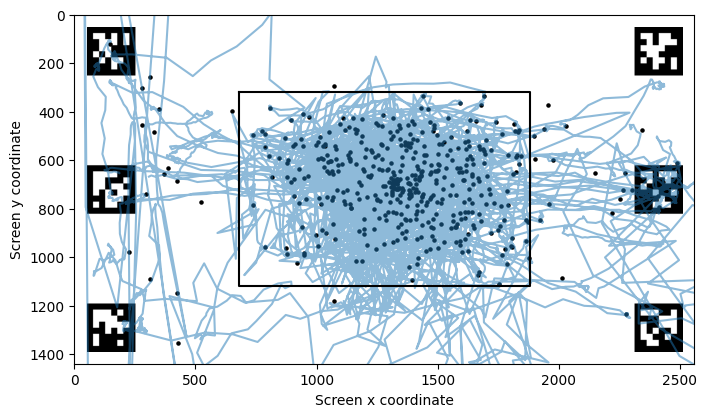

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_marker_layout(marker_layout, ax=ax, show_marker_names=False, show=False)
ax.plot(
    gaze_on_surface.data["gaze x [surface coord]"],
    gaze_on_surface.data["gaze y [surface coord]"],
    alpha=0.5,
)

ax.scatter(
    fixations_on_surface.data["fixation x [surface coord]"],
    fixations_on_surface.data["fixation y [surface coord]"],
    s=5,
    c="black",
)

# Plot where the artworks were
# There were 1200 x 800 pixels in size, centered on the screen (2560 x 1440)
ax.plot(
    [680, 1880, 1880, 680, 680],
    [320, 320, 1120, 1120, 320],
    color="black",
    label="Image outline",
)

ax.set_xlabel("Screen x coordinate")
ax.set_ylabel("Screen y coordinate")

ax.set_xlim(0, 2560)
ax.set_ylim(0, 1440)
ax.invert_yaxis()
plt.show()

## Example 2: ArUco Markers

The same workflow applies to ArUco markers. Instead of a family name, ArUco dictionaries are specified by their pattern (for example, `'5x5_50'`). The same four steps (detect, define coordinates, compute homography, transform) apply; only the marker family changes.

In [ ]:
rec = dataset.recordings[1]
video = rec.scene_video
detected_markers = video.detect_markers("5x5_50")

Detecting markers: 100%|██████████| 1044/1044 [00:13<00:00, 75.99it/s]


Using the shorter ArUco video, we will visualize detections across the full recording. Set `show_video=False` to avoid the interactive preview window and instead save the overlay to `output_path`.

In [ ]:
video.overlay_detections(
    detected_markers, show_video=False, output_path="export/marker_detections.mp4"
)

Overlaying detections on video: 100%|██████████| 1044/1044 [00:14<00:00, 71.18it/s]


## Alternative: Screen-Corner Detection

When fiducial markers are unavailable, estimate the homography from bright screen corners. The `detect_surface()` method looks for a bright rectangular contour per frame and returns its four corners. This works best when the screen is brighter than the background. You can tune `brightness_threshold`, `adaptive`, or `morph_kernel`, and use `step` or `detection_window` to speed up processing.

In [11]:
import numpy as np
from pyneon.video import find_homographies

screen_detections = video.detect_surface(step=10)

surface_corners = np.array(
    [
        [0, 0],
        [width, 0],
        [width, height],
        [0, height],
    ],
    dtype=np.float32,
)

homographies_screen = find_homographies(
    screen_detections,
    surface_layout=surface_corners,
)

Detecting surface corners: 100%|██████████| 732/732 [00:08<00:00, 85.96it/s]
C:\Users\Jan-G\Documents\GitHub\PyNeon\pyneon\tabular.py:67: UserWarning: Following columns not in known data types, using default data types: surface id
  warn(
Computing surface homographies: 100%|██████████| 702/702 [00:00<00:00, 1966.26it/s]


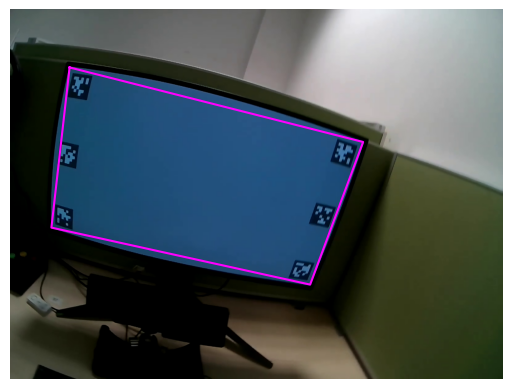

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [12]:
video.plot_detections(screen_detections, 500, show_ids=False)

In [13]:
video.overlay_detections(
    screen_detections,
    show_video=False,
    show_ids=False,
    output_path="export/surface_detections.mp4",
)

Overlaying detections on video:   5%|▌         | 366/7311 [00:04<01:16, 91.18it/s]


KeyboardInterrupt: 